In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
from qutip import *
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 20
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy,U = np.linalg.eigh(Hs)
    U_dag = np.conjugate(U.transpose())
    Hs = U_dag@Hs@U
    return Hs-energy[0]*np.identity(sdim),U_dag@(s+sd)@U


In [3]:
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2

In [15]:
import qutip as qt
def floquet_spec(omega,A,Ec,Ej,beta,phi_ex):
    N = 3 
    H0,Hc = SNAIL_H(phi_ex,beta,N,Ej,Ec)
    energies,U=np.linalg.eig(H0)
    energies = energies - energies[0]*np.ones(len(energies))
    energies = energies/2/np.pi
    # U_dag = np.conjugate(U.transpose())
    # U_dag@Hc@U
    energies = np.sort(energies)
    omega_s = energies[1]
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=1000000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    
    # Define your system dimension
    sdim = 20
    floquet_states = f_modes
    # Create your basis states
    basis_states = [qt.basis(sdim, i) for i in range(3)]
    # Initialize a list to hold the indices of the Floquet states with the maximum overlap for each basis state
    max_overlap_indices = [-1] * 3
    max_overlaps = [0] * 3
    # Loop over each Floquet state
    for f_index, f_state in enumerate(floquet_states):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energy01 = f_energies[max_overlap_indices[1]]/2/np.pi-f_energies[max_overlap_indices[0]]/2/np.pi
    k = find_optimal_k(omega_s, energy01, omega/2/np.pi)
    energy01 =energy01+k*omega/2/np.pi
    omega_ss = energy01-omega_s
    energy02 = f_energies[max_overlap_indices[2]]/2/np.pi-f_energies[max_overlap_indices[0]]/2/np.pi
    k = find_optimal_k(2*omega_s, energy02, omega/2/np.pi)
    energy02 =energy02+k*omega/2/np.pi
    anh = energy02 - energy01 - energy01
    if (max_overlaps<(np.sqrt(2)/2*np.ones(3))).all():
        omega_ss = 1000
        anh = 1000
    return energy01,energy02

In [27]:
omega = 2*2*np.pi
A = 0.5*2*np.pi
Ec = 0.7*2*np.pi
Ej = 15*2*np.pi
beta = 0.12
e_values = []
f_values = []
phi_ex_values = np.linspace(0, 0.5, 100)  # 50 points between 0 and 0.5
# Loop over phi_ex values
for phi_ex in phi_ex_values:
    e,f = floquet_spec(omega,A,Ec,Ej,beta,phi_ex) # Compute e for each phi_ex
    e_values.append(e)
    f_values.append(f)

In [28]:
floquet_spec(omega,A,Ec,Ej,beta,0)

(5.927074573551092, 11.616324935994346)

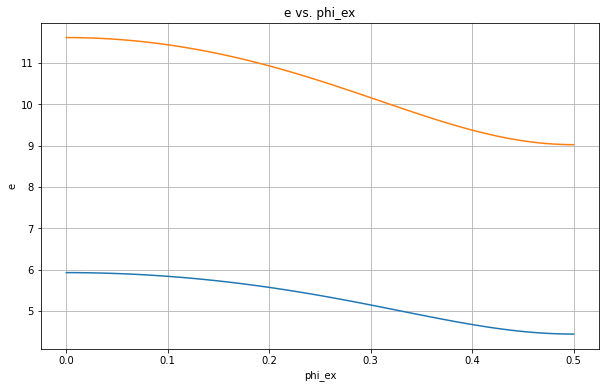

In [30]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(phi_ex_values, e_values)
plt.plot(phi_ex_values, f_values)
plt.xlabel('phi_ex')
plt.ylabel('e')
plt.title('e vs. phi_ex')
plt.grid(True)
plt.show()